In [35]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

import sklearn.metrics
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold
from sklearn.metrics import (
    confusion_matrix, mean_squared_error, roc_auc_score
)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, DMatrix

from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from catboost.datasets import titanic

# Градиентный бустинг на решающих деревьях

Бустинг &mdash; один из самых широко применяемых видов ансамблей моделей. В данном ноутбуке будут разобраны библиотеки `XGBoost` и `Yandex CatBoost`.

Материалы по теме:
- [XGBoost](https://github.com/dmlc/xgboost) &mdash; eXtreme Gradient Boosting;
- [Yandex CatBoost](https://github.com/catboost/catboost);
- [Сравнение библиотек (CatBoost vs. Light GBM vs. XGBoost)](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db).

`XGBoost` строит композицию из $T$ базовых моделей $b_t$:
$$ \widehat{y} = \widehat{y}_{T} = \sum_{t=1}^{T} b_t = \widehat{y}_{T - 1} + b_T, $$

минимизируя следующий функционал:

$$ Q = \sum_{i=1}^N \mathcal{L}\left(y_i, \widehat{y}_T(x_i)\right) + \sum_{t=1}^{T} R(b_t),$$

где
 - $n$ &mdash; размер обучающей выборки;
 - $x_i, y_i$ &mdash; объекты обучающей выборки, и соответствующие истинные значения отклика;
 - $\widehat{y}_{t}$ &mdash; композиция из $t$ уже обученных базовых моделей;
 - $R$ — регуляризатор;
 - $\mathcal{L}(y_i, \widehat{y}_i)$ &mdash; функция потерь.


Функционал, оптимизируемый на $t$-ой итерации:

$$ Q_t = \sum_{i=1}^N \mathcal{L}\left(y_i, \widehat{y}_{t-1}(x_i) + b_t(x_i)\right) + R(b_t) \longrightarrow \min_{b_t}.$$

В случае бустинга над решающими деревьями регуляризатор имеет следующий вид:

$$ R(b_t) = \eta J + \frac{1}{2}\lambda\sum_{j=1}^{J}\gamma_j^2 + \alpha\sum_{j=1}^{J}|\gamma_j|,$$

где 
 - $J$ &mdash; количество листьев в дереве;
 - $\gamma_j$ &mdash; ответы в листьях дерева;
 - $\lambda, \alpha, \gamma$ &mdash; гиперпараметры.

## 1. XGBoost

Будем обучать модели на датасете `Boston Housing`. Датасет содержит информацию о различных домах в Бостоне. Цель состоит в том, чтобы предсказать стоимость дома на основе $13$-ти признаков. Всего в датасете содержится $506$ домов.

Произведем загрузку данных:

In [36]:
boston = load_boston()
y = boston['target']
X = boston['data']

### 1.1 sklearn-интерфейс

Библиотека `XGBoost` имеет `sklearn`-like обертку, а именно, основные методы `fit` и `predict`. Это позволяет использовать `XGBoost`-модели в `sklearn`-утилитах, таких как `GridSearchCV` или `cross_val_score`. 
Для этого используются классы `XGBRegressor` или `XGBClassifier`.

Рассмотрим `XGBRegressor` и проведем кросс-валидацию на 3 фолда с помощью функции `cross_val_score` библиотеки `sklearn`:

In [37]:
xgb_model = XGBRegressor(
    silent=True, max_depth=4, n_estimators=200, random_state=42
)

cross_val_score(xgb_model, X, y, scoring='neg_mean_squared_error', cv=3)

[23:45:50] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:45:50] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:45:50] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

array([ -8.1982481 , -20.85520123, -51.91576648])

In [38]:
xgb_model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=4,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, silent=True, subsample=None,
             tree_method=None, validate_parameters=None, verbosity=None)>

Также мы можем провести кросс-валидацию с помощью функции `KFold`. С помощью неё разбить данные на 3 фолда и для каждого фолда посчитать ошибку на предсказании:

In [39]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

for fold_index, (train_index, test_index) in enumerate(kf.split(y)):
    # objective определяется, чтобы убрать warning
    xgb_model = XGBRegressor(
        objective ='reg:squarederror', random_state=42
    ).fit(X[train_index], y[train_index])
    
    xgb_predictions = xgb_model.predict(X[test_index])
    
    actuals = y[test_index]
    print("XGBoost RMSE on fold {}: {:.2f}".format(
        fold_index, np.sqrt(mean_squared_error(actuals, xgb_predictions)))
    )

XGBoost RMSE on fold 0: 2.83
XGBoost RMSE on fold 1: 4.22
XGBoost RMSE on fold 2: 2.90


### 1.2 Нативный интерфейс

У `XGBoost` также есть свой нативный интерфейс, и `sklearn`-интерфейс использует его внутри себя.

Переход из `sklearn`-интерфейса в нативный осуществляется с помощью метода `get_booster()`:

In [40]:
native_xgb_model = xgb_model.get_booster()

Для хранения данных в нативном интерфейсе используется класс `xgboost.DMatrix`. Он хранит в себе:
  - `data` &mdash; матрица объект-признак;
  - `label` &mdash; вектор с таргетом (для обучения и валидации);
  - `weight` &mdash; вектор весов объектов;
  - `feature_names` &mdash; названия признаков.
  
Данные можно легко перевести в объект `DMatrix` из `csv`-файла, `numpy`-массива и `pandas-dataframe`. 

В конструктор DMatrix можно передать следующие допольлнительные параметры:
  - `weight` &mdash; инициализация весов модели;
  - `missing` &mdash; константа для заполнения пропущенных значений.

In [41]:
xgtrain = DMatrix(X[train_index], label=y[train_index])
xgtest = DMatrix(X[test_index], label=y[test_index])

Функция `xgboost.train()` обучает модель. Принимает на вход `DMatrix`, словарь с гиперпараметрами модели и еще всякие опции для обучения через аргументы. 
 
Функция `xgboost.train()` возвращает класс `xgboost.booster` (бустер). У бустера есть метод `predict`, который делает предсказания.


[Подробнее](https://xgboost.readthedocs.io/en/latest/python/python_api.html)

Также в функцию `xgboost.train()` можно передать параметры с помощью словаря `params`, подробнее рассмотрим в следующем пункте.

In [42]:
params = {
    "objective": "reg:linear",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "max_depth": 6,
    "tree_method": "hist",
    "silent": True,
    "random_state": 42
}

bst = xgb.train(params, xgtrain, num_boost_round=20)

[23:45:51] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:51] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




### 1.3 Гиперпараметры XGBoost

В нативном интерфейсе гиперпараметры модели передаются в функцию `xgboost.train()` с помощью словаря `params`. В `sklearn`-интерфейсе параметры передаются в конструкторе при создании объекта класса.

### Основные параметры:

* `booster` &mdash; вид базовых моделей, например: <br>
    - `gbtree` &mdash; использует деревья;<br>
    - `dart` &mdash; использует деревья с dropout (вспоминаем прошлый семинар);<br>
    - `gblinear` &mdash; использует линейные модели.<br>

* `eta` или `learning rate` &mdash; скорость обучения;
* `gamma` &mdash; параметр в регуляризации на количество листьев;
* `max_depth` &mdash; максимальная глубина дерева;
* `subsample` &mdash; доля объектов, на которых обучается каждое дерево. Для каждого дерева выбирается свой набор;
* `alpha` &mdash; параметр `L1`-регуляризации;
* `lambda` &mdash; параметр `L2`-регуляризации;
* `tree_method` &mdash; параметр, отвечающий за метод перебора порогов и признаков при построении одного дерева. Возможные значения: `{auto, exact, approx, hist, gpu_exact, gpu_hist}`. Параметр будет описан в разделе про бинаризацию признаков;

* `objective` &mdash; лосс, который будем минимизировать: <br>
    - `reg:linear` &mdash; квадратичная ошибка;<br>
    - `reg:logistic` = `binary:logistic`. Единственная разница в том, что в случае регрессии в качестве `eval_metric` будет использоваться `RMSE`.<br>
    - также `binary:hinge`, `multi:softmax` и множество других для регрессии, бинарной/мульти классификации, ранжирования и прочих задач. <br>
    [Подробнее про доступные лоссы.](https://xgboost.readthedocs.io/en/latest/parameter.html)<br>

* `eval_metric` &mdash; измеряемая метрика. По умолчанию получается из параметра `objective`: для регрессии `RMSE`, для классификации - `error (он же: 1 - accuracy)`. <br>
Можно указать сразу несколько метрик, тогда будут измеряться сразу все. <br>
Возможные значения : `RMSE`, `MAE`, `logloss`, `error`, `AUC`  и множетсво остальных. <br>
[Подробнее про доступные метрики.](https://xgboost.readthedocs.io/en/latest/parameter.html) <br>

Параметры, которые указываются в аргументах функции `train()`, а не в словаре параметров:

* `num_boost_round` &mdash; количество базовых моделей. В `sklearn`-обертке за это отвечает параметр `n_estimators`;

* `evals` &mdash; в него можно передать массив вида `[(dtest, 'eval'), (dtrain, 'train')]`, где `dtest`, `dtrain` - `DMatrix`-объекты. Тогда после каждой итерации бустинга будет выводиться значение метрик из `eval_metric` для каждого из наборов;

* `early_stopping_rounds` &mdash;  в случае если этот параметр равен `k`, то после `k` итераций бустинга, которые не сопровождались уменьшением лосса для валидационного сета, указанного в `evals`, обучение будет остановлено.
<br>

Также для `XGBoost` есть возможность запускаться на `Hadoop`, `Spark`, `Flink` и `DataFlow`.

Обучим модель:

In [43]:
params = {
    "objective": "reg:linear",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "max_depth": 6,
    "tree_method": "hist",
    "silent": True,
    "random_state": 42
}

evallist = [(xgtest, 'eval'), (xgtrain, 'train')]
print("Вывод при обучении:")
bst = xgb.train(params, xgtrain, num_boost_round=20, evals=evallist)

print("\n\nРезультат на тестовых данных:\n", bst.eval(xgtest))

Вывод при обучении:
[23:45:51] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:51] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	eval-rmse:17.14712	train-rmse:17.04895
[1]	eval-rmse:12.44614	train-rmse:12.31893
[2]	eval-rmse:9.13073	train-rmse:8.97143
[3]	eval-rmse:6.97922	train-rmse:6.65307
[4]	eval-rmse:5.50160	train-rmse:5.00231
[5]	eval-rmse:4.48707	train-rmse:3.83908
[6]	eval-rmse:3.90017	train-rmse:3.02003
[7]	eval-rmse:3.52533	train-rmse:2.43168
[8]	eval-rmse:3.33127	train-rmse:1.99241
[9]	eval-rmse:3.21670	train-rmse:1.69849
[10]	eval-rmse:3.16255	train-rmse:1.49532
[11]	eval-rmse:3.10998	train-rmse:1.32896
[12]	e

Также можем использовать кросс-валидацию:



In [44]:
params = {
    "objective": "reg:linear",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "max_depth": 6,
    "tree_method": "hist",
    "silent": True,
    "random_state": 42
}

for fold_index, (train_index, test_index) in enumerate(kf.split(y)):    
    xgtrain = DMatrix(X[train_index], label=y[train_index])
    xgtest = DMatrix(X[test_index], label=y[test_index])

    bst = xgb.train(params, xgtrain, num_boost_round=100)

    print("Результат для {} фолда: {}".format(fold_index, bst.eval(xgtest)))

[23:45:52] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:52] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Результат для 0 фолда: [0]	eval-rmse:3.111262
[23:45:52] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:52] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Ре

### 1.4 Своя функция потерь

В `XGBoost` имеется возможность реализовать свои метрики и функции потерь. Для функций потерь необходимо уметь считать градиент и гессиан (точнее, его главную диагональ).

Разделим данные на `train`, `val` и `test`:

In [45]:
X_train, X_rest, y_train, y_rest = train_test_split(
    X, y, test_size=0.25, random_state=42
)
X_validate, X_test, y_validate, y_test = train_test_split(
    X_rest, y_rest, test_size=0.5, random_state=42
)

Определим свою функцию потерь MSE. Она должна возвращать градиент и главную диагональ гессиана:

In [46]:
def my_xgb_reg_linear(preds, dtrain):
    # извлекаем истинные метки классов
    labels = dtrain.get_label()
    # градиент функции потерь по ответам
    grad = (preds - labels)
    # вторые производные
    hess = np.ones(labels.shape[0])
    return grad, hess

Обучим нашу модель, используя свою функцию потерь. Качество на тесте и валидации &mdash; `RMSE`:

In [47]:
xgtrain = xgb.DMatrix(X_train, label=y_train, 
                      feature_names=boston['feature_names'])
xgvalidate = xgb.DMatrix(X_validate, label=y_validate, 
                         feature_names=boston['feature_names'])
xgtest = xgb.DMatrix(X_test, label=y_test, 
                     feature_names=boston['feature_names'])

print("Вывод при обучении:")
bst = xgb.train(
    params, xgtrain, num_boost_round=200, obj=my_xgb_reg_linear,
    evals=[(xgvalidate, "validate"), (xgtest, "test")], verbose_eval=50
)

print("\n\nРезультат на тестовых данных:\n", bst.eval(xgtest))

Вывод при обучении:
[23:45:53] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:53] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validate-rmse:15.48851	test-rmse:16.76330
[50]	validate-rmse:2.60846	test-rmse:3.36515
[100]	validate-rmse:2.59692	test-rmse:3.35302
[150]	validate-rmse:2.59538	test-rmse:3.35185
[199]	validate-rmse:2.59552	test-rmse:3.35174


Результат на тестовых данных:
 [0]	eval-rmse:3.351737


### 1.5 Важность признаков



С помощью функции `get_fscore` мы можем посмотреть сколько раз каждый признак использовался в качестве разделяющего при построении дерева:

In [48]:
# Обучение модели
params = {
    "objective": "reg:linear",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "max_depth": 6,
    "tree_method": "hist",
    "silent": True,
    "random_state": 42
}
bst = xgb.train(params, xgtrain, num_boost_round=100)

# Важность признаков
fstrs = bst.get_fscore()

# Печать
for name, value in Counter(bst.get_fscore()).most_common():
    print("{}\t{}".format(name, value))

[23:45:53] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:53] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CRIM	744.0
RM	449.0
AGE	383.0
DIS	306.0
LSTAT	294.0
B	266.0
NOX	177.0
INDUS	113.0
TAX	73.0
PTRATIO	72.0
ZN	67.0
RAD	36.0
CHAS	16.0


Отрисуем график Feature inportance для нашего бустинга:

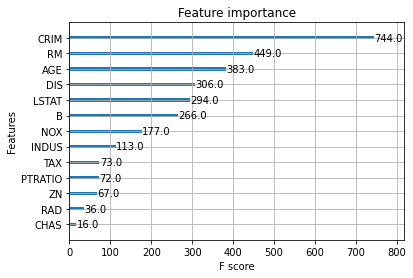

In [49]:
xgb.plot_importance(bst)
plt.show()

### 1.6 Бинаризация признаков в XGBoost

Использовать все возможные значения каждого признака для выбора разбиения &mdash; очень накладно. Поэтому обычно значения признака разбиваются на небольшое число корзин (бины). Существуют разные стратегии выбора бинов.

Стратегии задаются параметром `tree_method`. 

Возможные значения:
  - `exact` &mdash; используются всевозможные значения факторов;
  - `approx` &mdash; на каждой итерации бины пересчитываются в зависимости от значений градиента. Более того, можно пересчитывать локально для каждой вершины строящегося дерева. Параметр `sketch_eps` задает примерное кол-во бинов: число бинов равно примерно `1/sketch_eps`;
  - `hist` &mdash; гистограмма, которая считается один раз перед обучением. Работает в 8-10 раз быстрее выше представленных стратегий без особой потери качества.

In [50]:
for tree_method in ["exact", "approx", "hist"]:
    params = {
        "tree_method": tree_method,
        "sketch_eps": 0.2,
        "silent": True
    }
    bst = xgb.train(params, xgtrain, num_boost_round=100)
    print("Метод бинаризации: {}\nРезультат на валидации: {}\n".format(tree_method, 
                                                 bst.eval(xgvalidate)))

[23:45:54] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Метод бинаризации: exact
Результат на валидации: [0]	eval-rmse:2.534564

[23:45:54] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Метод бинаризации: approx
Результат на валидации: [0]	eval-rmse:2.816162

[23:45:54] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameter

## 2. CatBoost

Рассмотрим теперь ещё одну библиотеку: `CatBoost` от `Yandex`.

Аналогом для класса `DMatrix` в `CatBoost` служит класс `catboost.Pool` Помимо прочего, этот класс содержит индексы категориальных признаков. [Подробнее про catboost.Pool](https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_pool-docpage/).

Деревья в `CatBoost` строятся по слоям. При этом используются `oblivious decision trees`, то есть на каждом уровне дерева выбирается общее правило ветвления для всех вершин на этом уровне. Сплит выбирается из соображений наилучшего приближения вектора градиента.

Для выбора количества деревьев нужно указать один из параметров: `iterations`, `num_boost_round`, `n_estimators`, `num_trees` (это все синонимы).

Классы `CatBoostClassifier` и `CatBoostRegressor` можно использовать в `GridSearch` и других `sklearn` методах, так как они имеют такой же интерфейс.

С поддерживаемыми метриками и функциями потерь можно ознакомиться по [ссылке](https://tech.yandex.com/catboost/doc/dg/concepts/loss-functions-docpage/#loss-functions__regression).

Аналогично будем обучать модели на датасете `Boston Housing`. 

Произведем загрузку данных:

In [51]:
boston = load_boston()
y = boston['target']
X = boston['data']

Рассмотрим `CatBoostRegressor` и проведем кросс-валидацию на 3 фолда с помощью функции `cross_val_score` библиотеки `sklearn`:

In [52]:
cb_model = CatBoostRegressor(silent=True, random_state=42)

cross_val_score(cb_model, X[train_index], y[train_index], 
                scoring='neg_mean_squared_error', cv=3)

array([ -6.41301696, -41.88990983, -48.83178757])

Также мы можем провести кросс-валидацию с помощью функции `KFold`. С помощью неё разбить данные на 3 фолда и для каждого фолда посчитать ошибку на предсказании:

In [53]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

for fold_index, (train_index, test_index) in enumerate(kf.split(y)):
    cb_model = CatBoostRegressor(
        silent=True, random_state=42
    ).fit(X[train_index], y[train_index])

    cb_predictions = cb_model.predict(X[test_index])
    
    actuals = y[test_index]
    print("CatBoost RMSE on fold {}: {:.2f}".format(
        fold_index, np.sqrt(mean_squared_error(actuals, cb_predictions))
    ))

CatBoost RMSE on fold 0: 2.90
CatBoost RMSE on fold 1: 3.80
CatBoost RMSE on fold 2: 2.81


Используем `Pool` для хранения данных.

В конструктор `Pool` можно передать дополнительные параметры, например:
* `weight` &mdash; позволяет присвоить объектам веса;
* `cat_features` &mdash; индексы категориальных признаков.

In [54]:
train_data = Pool(
    data=X[train_index],
    label=y[train_index],
    weight=np.random.rand(len(train_index))  # Присваиваем веса объектам, если хотим
    # cat_features=[0,2,5]
)

test_data = Pool(
    data=X[test_index],
)

Обучение модели и предсказание:

In [55]:
model = CatBoostRegressor(silent=True, random_state=42)

model.fit(train_data)
cb_predictions = model.predict(test_data)
actuals = y[test_index]
print("CatBoost MSE: {:.2f}".format(
    np.sqrt(mean_squared_error(actuals, cb_predictions))
))

CatBoost MSE: 2.94


### 2.1 Своя функция потерь в CatBoost

Можно написать свою функцию потерь и передать её в `CatBoost`. В качестве аргументов ана должна принимать предсказания, целевые метки и веса объектов, а возвращать список пар из градиента и гессиана: каждому объекту по паре. [Пример реализации logloss](https://tech.yandex.com/catboost/doc/dg/concepts/python-usages-examples-docpage/#custom-objective-function).

Реализуем `взвешенную MSE`. Так как функцию потерь в `CatBoost` необходимо **максимизировать**, то в нашем случае она поменяет знак:

$$ \mathcal{L}\left(y_i, p_i, w_i\right) = -\frac{1}{2}w_i(p_i - y_i)^2, $$
где
 - $y_i$ &mdash; истинные метки;
 - $p_i$ &mdash; наши предсказания;
 - $w_i$ &mdash; веса объектов, задаваемые пользователем.

In [56]:
class MyCatBoostRegLinear(object):
    def calc_ders_range(self, approxes, targets, weights=None):
        '''
        Реализация функции потерь.
        Аргументы:
        * approxes -- предсказания
        * targets -- целевые метки
        * weights -- веса объектов
        
        Возвращает список, в котором для каждого 
        объекта выборки находится tuple из градиента и гессиана.
        '''

        assert len(approxes) == len(targets)
        
        # Если веса не заданы, то есть обычное MSE
        if weights is None:
            return [(-approxes[i] + targets[i], -1.0) 
                    for i in range(len(approxes))]
        
        # Если веса заданы, то есть взвешенное MSE
        else:
            assert len(approxes) == len(weights)
            return [(-weights[i] * (approxes[i] - targets[i]), -weights[i])
                    for i in range(len(approxes))]


Обучим катбуст с нашей функцией потерь

In [57]:
cb = CatBoostRegressor(metric_period=100,
                       loss_function=MyCatBoostRegLinear(),
                       eval_metric="RMSE", random_state=42)

cb.fit(X_train, y_train, eval_set=[(X_validate, y_validate)])
pred = cb.predict(X[test_index])

print("RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y[test_index], pred))))

0:	learn: 24.1703734	test: 21.8492408	best: 21.8492408 (0)	total: 131ms	remaining: 2m 11s
100:	learn: 4.0323601	test: 3.2763921	best: 3.2763921 (100)	total: 202ms	remaining: 1.8s
200:	learn: 2.2967889	test: 2.4738771	best: 2.4738771 (200)	total: 276ms	remaining: 1.1s
300:	learn: 1.8577502	test: 2.3253302	best: 2.3253302 (300)	total: 356ms	remaining: 827ms
400:	learn: 1.5855192	test: 2.2795508	best: 2.2795508 (400)	total: 432ms	remaining: 646ms
500:	learn: 1.3276959	test: 2.2513366	best: 2.2513366 (500)	total: 507ms	remaining: 505ms
600:	learn: 1.1443431	test: 2.2308101	best: 2.2308101 (600)	total: 588ms	remaining: 390ms
700:	learn: 1.0026655	test: 2.2352036	best: 2.2308101 (600)	total: 668ms	remaining: 285ms
800:	learn: 0.8662814	test: 2.2349875	best: 2.2308101 (600)	total: 746ms	remaining: 185ms
900:	learn: 0.7552495	test: 2.2464049	best: 2.2308101 (600)	total: 837ms	remaining: 92ms
999:	learn: 0.6744016	test: 2.2474681	best: 2.2308101 (600)	total: 924ms	remaining: 0us

bestTest = 2.2

### 2.2 Визуализация

В `CatBoost` имеется возможность строить кривые обучения в режиме реального времени. Для сохранения графиков в ноутбуке нужно нажать `Widgets` -> `Save Notebook Widget State`.

Ниже изображены функции потерь для обучаещих, валидационных и тестовых данных.

In [58]:
cb = CatBoostRegressor(
    silent=True, eval_metric="MAE", custom_metric=["MAPE"], random_state=42
)
cb.fit(X_train, y_train, 
       eval_set=[(X_validate, y_validate), (X_test, y_test)], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 ### 2.3 Бинаризация признаков в CatBoost
 
 Использовать все возможные значения каждого признака для выбора разбиения &mdash; очень накладно. Поэтому обычно значения признака разбиваются на небольшое число корзин (бины). Существуют разные стратегии выбора бинов.
 
 Выбрать стратегию бинаризации можно, установив параметр `feature_border_type`.
 
  - `Uniform` &mdash; границы выбираются равномерно по значениям;
  - `Median` &mdash; в каждый бин попадает примерно одинаковое число различных значений;
  - `UniformAndQuantiles` &mdash; комбинируем результаты бинаризации методом Uniform и Median предварительно уменьшив вдвое параметр бинаризации для каждого из них;
  - `MaxLogSum, GreedyLogSum` максимизируется значение формулы $\sum_{i=1}^K \log(n_i)$, где $K$ &mdash; требуемое кол-во бинов, $n_i$ &mdash; число объектов в этом бакете;
  - `MinEntropy` &mdash; аналогично, но максимизируется энтропия: $-\sum_{i=1}^K n_i \log(n_i)$.

Для каждой стратегии бинаризации посчитаем `MSE` и найдем оптимальную:

In [25]:
params = {
    "feature_border_type": [
      "Uniform",
      "Median",
      "UniformAndQuantiles",
      "MaxLogSum",
      "GreedyLogSum",
      "MinEntropy"
      ]
}

cb = CatBoostRegressor(silent=True, random_state=42)
grid = GridSearchCV(cb, params, cv=5)
grid.fit(X, y)

for score, strategy in sorted(
    zip(grid.cv_results_['mean_test_score'],
    grid.cv_results_['param_feature_border_type'].data)
):
    print("MSE: {:.3f}, strategy: {}".format(score, strategy))

MSE: 0.659, strategy: MinEntropy
MSE: 0.663, strategy: GreedyLogSum
MSE: 0.669, strategy: MaxLogSum
MSE: 0.670, strategy: Median
MSE: 0.681, strategy: UniformAndQuantiles
MSE: 0.681, strategy: Uniform


### 2.4 Важность признаков

In [26]:
cb = CatBoostRegressor(silent=True, random_state=42)
cb.fit(X_train, y_train)

for value, name in sorted(
    zip(cb.get_feature_importance(fstr_type="FeatureImportance"), 
        boston["feature_names"]), 
    reverse=True
):
    print("{}\t{:.2f}".format(name, value))

LSTAT	31.07
RM	29.17
DIS	6.63
CRIM	5.20
AGE	4.97
B	4.17
PTRATIO	3.80
NOX	3.75
TAX	3.56
INDUS	2.63
RAD	2.58
CHAS	1.53
ZN	0.93


Важность признаков нормализована так, чтобы сумма равнялась $100$. Этого можно достичь, так как все значения неотрицаельны. 

### 2.5 Категориальные признаки

Одно из основных преимуществ `CatBoost` &mdash; обработка категориальных признаков.

Если количество различных значений признака небольшое, то для его кодировки применяется `one-hot-encodding`.
Иначе применяется `target-encoding`: признак заменяется на статистики по тагретам объектов, которые имеют данное значение категориального признака.

Такие манипуляции очень легко могут привести к переобучению, потому что в данные подмешивается информация о метках объектов, после чего происходит обучение. `CatBoost` инкапсулирует все эти опасные вычисления.

Особенности работы с категориальными факторами: 

  - объекты перемешиваются в случайном порядке;
  - для $i$-го объекта в перестановке статистика вычисляется по всем объектам, идущим **до него**, категориальный фактор заменяется на числовой;
  - среднее сглаживается некоторым априорным приближением;
  - по факту обучается несколько (3) модели на разных перестановках;
  - рассматриваются композиции категориальных факторов (`max_ctr_complexity`);
  - в момент применения модели, новые объекты приписываются в конец перестановки по обучающей выборке и, таким образом, статистика для них считается по всем имеющимся данным;
  - таргето-независимые статистики (`mean-encoding`) считаются по всем данным;
  - для факторов с небольшим числом различных значений производится `OneHotEncoding` (параметр `one_hot_max_size` &mdash; максимальное значение для `OneHotEncoding'а`).

Попробуем поработать с категориальными признаками на датасете титаник. В нем представлена базовая информация о пассажире лайнера, а также бинарная метка выжил/не выжил в крушении, которую и требуется предсказать.

In [27]:
titanic_df = titanic()

X = titanic_df[0].drop('Survived', axis=1)
y = titanic_df[0].Survived

In [28]:
X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Найдем категориальные столбцы, а также заполним пропуски в них строкой "NAN":

In [29]:
is_cat = (X.dtypes != float)

for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X[feature].fillna("NAN", inplace=True)

cat_features_index = np.where(is_cat)[0]

Создаем `Pool`, в которых кроме прочего указываем индексы категориальных столбцов.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.85, random_state=1234
)

train_pool = Pool(X_train, label=y_train, cat_features=cat_features_index, 
                  feature_names=list(X_train.columns))
test_pool = Pool(X_test, label=y_test, cat_features=cat_features_index, 
                 feature_names=list(X_test.columns))

Обучаем `CatBoostClassifier`. Будем после каждых `metric_period=100` итераций смотреть на метрику на `eval_set`-е. В итоге будем использовать модель, полученную на лучшей по метрике итерации (`use_best_model=True`).

In [31]:
model = CatBoostClassifier(eval_metric='Accuracy', 
                           use_best_model=True, random_seed=0)

model.fit(train_pool, eval_set=test_pool, metric_period=100)
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:, 1])

Learning rate set to 0.029583
0:	learn: 0.7820343	test: 0.8134328	best: 0.8134328 (0)	total: 2.04ms	remaining: 2.03s
100:	learn: 0.8692206	test: 0.8208955	best: 0.8208955 (100)	total: 225ms	remaining: 2s
200:	learn: 0.8771466	test: 0.8358209	best: 0.8358209 (200)	total: 425ms	remaining: 1.69s
300:	learn: 0.8956407	test: 0.8358209	best: 0.8358209 (200)	total: 690ms	remaining: 1.6s
400:	learn: 0.9141347	test: 0.8507463	best: 0.8507463 (400)	total: 957ms	remaining: 1.43s
500:	learn: 0.9233818	test: 0.8432836	best: 0.8507463 (400)	total: 1.23s	remaining: 1.22s
600:	learn: 0.9392338	test: 0.8507463	best: 0.8507463 (400)	total: 1.51s	remaining: 1s
700:	learn: 0.9458388	test: 0.8432836	best: 0.8507463 (400)	total: 1.84s	remaining: 785ms
800:	learn: 0.9511229	test: 0.8507463	best: 0.8507463 (400)	total: 2.1s	remaining: 523ms
900:	learn: 0.9577279	test: 0.8432836	best: 0.8507463 (400)	total: 2.37s	remaining: 261ms
999:	learn: 0.9630119	test: 0.8358209	best: 0.8507463 (400)	total: 2.68s	remainin

0.8860759493670884

**Вывод:**

таким образом мы рассмотрели две популярные библиотеки для бутсинга `XGBoost` и `CatBoost`. В `CatBoost` удобно работать с категориальными признаками и реализована красивая визуализация, `XGBoost` больше распространен.